# Lane Detection

## Pipeline
1) Grayscale Conversion

2) Gaussian Blur

3) Canny Edge Detection

4) Region of Interest

5) Hough Transform

6) Draw Lines

### Importing Packages

In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

### Reading an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


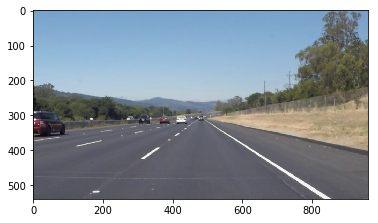

In [5]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)

### Helper Functions

In [6]:
import math

def perp( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

def seg_intersect(a1,a2, b1,b2):
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

def movingAverage(avg, new_sample, N=20):
    if (avg == 0):
        return new_sample
    avg -= avg / N;
    avg += new_sample / N;
    return avg;

# Grayscale Conversion
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Canny Edge Detection
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

# Gaussian Blur
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Region of Interest
def region_of_interest(img, vertices):
    #defining a blank mask
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
           
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    # variables to keep track of most dominant segment
    largestLeftLineSize = 0
    largestRightLineSize = 0
    largestLeftLine = (0,0,0,0)
    largestRightLine = (0,0,0,0)
    
    global avgLeft
    global avgRight

    if lines is None:
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            size = math.hypot(x2 - x1, y2 - y1)
            slope = ((y2-y1)/(x2-x1))
            
            # find the most dominent segment based on length
            if (slope > 0.5): #right lane
                if (size > largestRightLineSize):
                    largestRightLine = (x1, y1, x2, y2)                    
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            elif (slope < -0.5): #left lane
                if (size > largestLeftLineSize):
                    largestLeftLine = (x1, y1, x2, y2)
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    # Define an imaginary horizontal line in the center of the screen
    # and at the bottom of the image, to extrapolate determined segment
    imgHeight, imgWidth = (img.shape[0], img.shape[1])
    upLinePoint1 = np.array( [0, int(imgHeight - (imgHeight/3))] )
    upLinePoint2 = np.array( [int(imgWidth), int(imgHeight - (imgHeight/3))] )
    downLinePoint1 = np.array( [0, int(imgHeight)] )
    downLinePoint2 = np.array( [int(imgWidth), int(imgHeight)] )
    
    # Find the intersection of dominant lane with an imaginary horizontal line
    # in the middle of the image and at the bottom of the image.
    p3 = np.array( [largestLeftLine[0], largestLeftLine[1]] )
    p4 = np.array( [largestLeftLine[2], largestLeftLine[3]] )
    upLeftPoint = seg_intersect(upLinePoint1,upLinePoint2, p3,p4)
    downLeftPoint = seg_intersect(downLinePoint1,downLinePoint2, p3,p4)
    if (math.isnan(upLeftPoint[0]) or math.isnan(downLeftPoint[0])):
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return
    cv2.line(img, (int(upLeftPoint[0]), int(upLeftPoint[1])), (int(downLeftPoint[0]), int(downLeftPoint[1])), [0, 0, 255], 8) #draw left line

    # Calculate the average position of detected left lane over multiple video frames and draw
    
    avgx1, avgy1, avgx2, avgy2 = avgLeft
    avgLeft = (movingAverage(avgx1, upLeftPoint[0]), movingAverage(avgy1, upLeftPoint[1]), movingAverage(avgx2, downLeftPoint[0]), movingAverage(avgy2, downLeftPoint[1]))
    avgx1, avgy1, avgx2, avgy2 = avgLeft
    cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line

    # Find the intersection of dominant lane with an imaginary horizontal line
    # in the middle of the image and at the bottom of the image.
    p5 = np.array( [largestRightLine[0], largestRightLine[1]] )
    p6 = np.array( [largestRightLine[2], largestRightLine[3]] )
    upRightPoint = seg_intersect(upLinePoint1,upLinePoint2, p5,p6)
    downRightPoint = seg_intersect(downLinePoint1,downLinePoint2, p5,p6)
    if (math.isnan(upRightPoint[0]) or math.isnan(downRightPoint[0])):
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return
    cv2.line(img, (int(upRightPoint[0]), int(upRightPoint[1])), (int(downRightPoint[0]), int(downRightPoint[1])), [0, 0, 255], 8) #draw left line

    # Calculate the average position of detected right lane over multiple video frames and draw
    
    avgx1, avgy1, avgx2, avgy2 = avgRight
    avgRight = (movingAverage(avgx1, upRightPoint[0]), movingAverage(avgy1, upRightPoint[1]), movingAverage(avgx2, downRightPoint[0]), movingAverage(avgy2, downRightPoint[1]))
    avgx1, avgy1, avgx2, avgy2 = avgRight
    cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Driver Function 

In [7]:
def process_image(image):

    # Blur to avoid edges from noise
    blurredImage = gaussian_blur(image, 11)
    

    edgesImage = canny(blurredImage, 40, 50)
    
    # mark out the trapezium region of interest

    height = image.shape[0]
    width = image.shape[1]
    vertices = np.array( [[
                [3*width/4, 3*height/5],
                [width/4, 3*height/5],
                [40, height],
                [width - 40, height]
            ]], dtype=np.int32 )
    
   
    regionInterestImage = region_of_interest(edgesImage, vertices)
    
  
    lineMarkedImage = hough_lines(regionInterestImage, 1, np.pi/180, 40, 30, 200)
    

    # draw output on top of original
    return weighted_img(lineMarkedImage, image)


### Test on Images

In [8]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
inDirectory = "test_images"
outDirectory = inDirectory + "_out"
if not os.path.exists(outDirectory):
    os.makedirs(outDirectory)
imageNames = os.listdir(inDirectory + "/")
for imageName in imageNames:
    avgLeft = (0, 0, 0, 0)
    avgRight = (0, 0, 0, 0)
    image = mpimg.imread(inDirectory + "/" + imageName)
    out = process_image(image)
    mpimg.imsave(outDirectory + "/" + imageName, out)
    print("Processed " + outDirectory + "/" + imageName)
print("Processing complete.")

Processed test_images_out/solidYellowCurve2.jpg
Processed test_images_out/trees1.jpg
Processed test_images_out/IMG_0022.jpg
Processed test_images_out/solidWhiteRight.jpg


/home/siddhantsahu/.conda/envs/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/siddhantsahu/.conda/envs/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


Processed test_images_out/DSC02681.JPG
Processed test_images_out/IMG_4923.jpg
Processed test_images_out/IMG_4920.jpg
Processed test_images_out/DSC02668.JPG
Processed test_images_out/curvy1.jpg
Processed test_images_out/whiteCarLaneSwitch.jpg
Processed test_images_out/IMG_4922.jpg
Processed test_images_out/solidWhiteCurve.jpg
Processed test_images_out/solidYellowLeft.jpg
Processed test_images_out/IMG_4921.jpg
Processed test_images_out/DSC02673.JPG
Processed test_images_out/IMG_4919.jpg
Processed test_images_out/IMG_0023.jpg
Processed test_images_out/solidYellowCurve.jpg
Processed test_images_out/DSC02670.JPG
Processed test_images_out/DSC02680.JPG
Processing complete.


### Plot a Processed Images

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 4)
This image is: <class 'numpy.ndarray'> with dimesions: (1067, 1904, 4)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 960, 4)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 4)
This image is: <class 'numpy.ndarray'> with dimesions: (719, 1280, 4)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 960, 4)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 960, 4)
This image is: <class 'numpy.ndarray'> with dimesions: (719, 1280, 4)
This image is: <class 'numpy.ndarray'> with dimesions: (1376, 2440, 4)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 4)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 960, 4)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 4)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 4)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 960, 4)
This image is: <class 'numpy

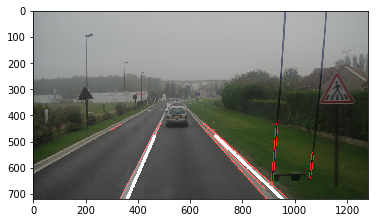

In [9]:
imageNames = os.listdir("test_images_out")
for imageName in imageNames:
    image = mpimg.imread("test_images_out/" + imageName)
    print('This image is:', type(image), 'with dimesions:', image.shape)
    plt.imshow(image)
print("Processing complete")

In [10]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# reset global state of average values
avgLeft = (0, 0, 0, 0)
avgRight = (0, 0, 0, 0)

white_output = 'white.mp4'
clip1 = VideoFileClip("video/solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 34.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 5.26 s, sys: 171 ms, total: 5.43 s
Wall time: 7.14 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [12]:
# reset global state of average values
avgLeft = (0, 0, 0, 0)
avgRight = (0, 0, 0, 0)

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('video/solidYellowLeft.mp4')

yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:21<00:00, 31.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 17.3 s, sys: 557 ms, total: 17.9 s
Wall time: 22.3 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))